In [ ]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
import sympy
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot

from SimPEG.EM import TDEM
from SimPEG.EM.Static import DC
from SimPEG import Utils, Maps

from geoana.em import tdem

import casingSimulations

from pymatsolver import Pardiso

%matplotlib inline

In [ ]:
sigma_back = 1e-1

In [ ]:
csx, ncx, npadx = 1, 50, 30
ncy = 10
csz, ncz, npadz = 1, 50, 30

hx = Utils.meshTensor([(csx, ncx), (csx, npadx, 1.3)])
hy = 2*np.pi / ncy * np.ones(ncy)
hz = Utils.meshTensor([(csz, npadz, -1.3), (csz, ncz), (csz, npadz, 1.3)])

In [ ]:
mesh2D = discretize.CylMesh([hx, 1., hz], x0='00C')
mesh2D.plotGrid()

In [5]:
src_a = np.r_[csx/2., 0., -csz*7/2.]
src_b = np.r_[csx/2., 0., csz*7/2.]

(-10.0, 10.0)

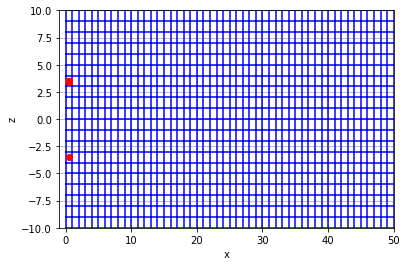

In [6]:
fig, ax = plt.subplots(1, 1)
mesh2D.plotGrid(ax=ax)

ax.plot(src_a[0], src_a[2], 'ro')
ax.plot(src_b[0], src_b[2], 'rs')

ax.set_xlim([-1., 50.])
ax.set_ylim([-10., 10.])

## DC problem

In [7]:
srcDC = DC.Src.Dipole([], src_a, src_b)
prob2DDC = DC.Problem3D_CC(mesh2D, sigmaMap=Maps.SurjectFull(mesh2D), bc_type='Dirichlet', Solver=Pardiso)
survey2DDC = DC.Survey([srcDC])
prob2DDC.pair(survey2DDC)

Homogeneous Dirichlet is the natural BC for this CC discretization.


In [8]:
%time
fields2DDC = prob2DDC.fields(np.r_[sigma_back])

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


## TDEM problem

In [22]:
dg_x = np.zeros(mesh2D.vnF[0])
dg_y = np.zeros(mesh2D.vnF[1])
dg_z = np.zeros(mesh2D.vnF[2])

wire_in_boreholex = (
    (mesh2D.gridFz[:, 0] < src_a[0] + mesh2D.hx.min()/2.) &
    (mesh2D.gridFz[:, 0] > src_a[0] - mesh2D.hx.min()/2.)
)
wire_in_boreholez = (
    (mesh2D.gridFz[:, 2] >= src_a[2] - 0.5*mesh2D.hz.min()) &
    (mesh2D.gridFz[:, 2] < src_b[2] + 0.5*mesh2D.hz.min())
)

wire_in_borehole = wire_in_boreholex & wire_in_boreholez

dg_z[wire_in_borehole] = 1.

# assemble the source (downhole grounded primary)
dg = np.hstack([dg_x, dg_y, dg_z])
src = TDEM.Src.RawVec_Grounded([], s_e=dg/mesh2D.area)

In [34]:
# solve the problem at these times
timeSteps = [(1e-6, 20), (1e-5, 20), (1e-4, 10)] 

# define a problem - the statement of which discrete pde system we want to solve
prob = TDEM.Problem3D_j(mesh2D, timeSteps = timeSteps, sigmaMap=Maps.SurjectFull(mesh2D))  
prob.solver = Pardiso

survey = TDEM.Survey([src])

# tell the problem and survey about each other - so the RHS can be constructed for 
# the problem and the resulting fields and fluxes can be sampled by the receiver. 
prob.pair(survey)  

print('The maximum time is {:1.1e}'.format(prob.times[-1]))

The maximum time is 1.2e-03


In [35]:
%%time
fields = prob.fields(np.r_[sigma_back])

CPU times: user 15.2 s, sys: 528 ms, total: 15.7 s
Wall time: 8.53 s


In [36]:
# log-scale the colorbar
from matplotlib.colors import LogNorm 
import ipywidgets

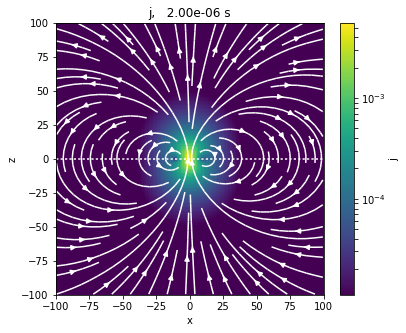

<function __main__.plot_j>

In [37]:
def plot_j(
    time_ind=0 # which frequency would you like to look at?
):
    fig, ax = plt.subplots(1,1, figsize=(6,5))
    
    # Plot the magnetic flux
    field_to_plot = fields[src, 'j', time_ind]
    max_field = np.abs(field_to_plot).max() #use to set colorbar limits
    cb_range = 5e2  # dynamic range of colorbar
    
    cb = plt.colorbar(mesh2D.plotImage(
        field_to_plot, 
        vType='F', view='vec', 
        range_x=[-100., 100.], range_y=[-100., 100.],
        pcolorOpts={
                'norm': LogNorm(), 
                'cmap': plt.get_cmap('viridis')
            },
        streamOpts={'color': 'w'}, mirror=True, ax=ax, 
        clim=[max_field/cb_range, max_field]
    )[0], ax=ax)

    cb.set_label('j')
    
    # plot the surface of the earth
    ax.plot(np.r_[-200, 200], np.r_[0., 0.], 'w:')

    # give it a title
    ax.set_title(
        'j, {time:10.2e} s'.format( 
            time=prob.times[time_ind]
        )
    )
    plt.show()
    return ax

ipywidgets.interact(
    plot_j, 
    time_ind=ipywidgets.IntSlider(min=2, max=len(prob.timeSteps)-1, value=1) 
)

In [38]:
wirez = mesh2D.gridFz[wire_in_borehole, 2]
loc = wirez

In [39]:
ana_dipole = tdem.ElectricDipole(sigma=sigma_back, time=prob.times[1], orientation='Z', length=src_b[2]-src_a[2] + csz)

In [40]:
ana_dipole.sigma

0.1

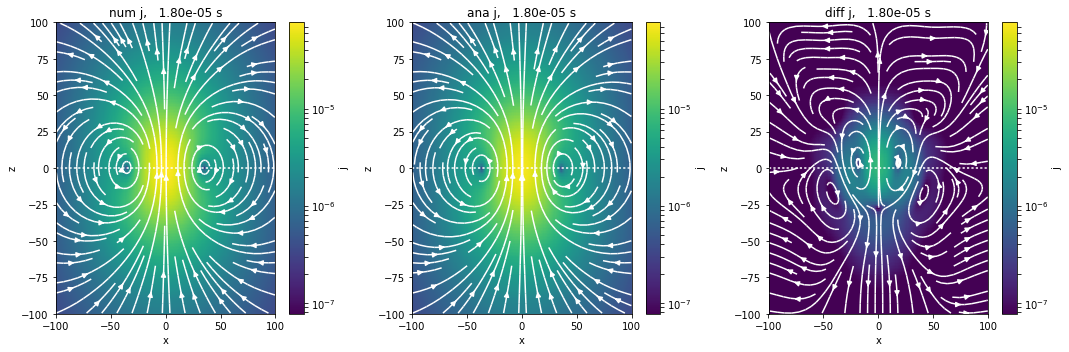

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11d445090>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x118d06b50>], dtype=object)

In [41]:
def plot_j(
    time_ind=0 # which frequency would you like to look at?
):
    fig, ax = plt.subplots(1,3, figsize=(15,5))
    
    # Numeric solution
    numeric = fields[src, 'j', time_ind]
    
    # analytic solution
    ana_dipole.time = prob.times[time_ind]
    
    j_x_ana = utils.mkvc(ana_dipole.current_density(mesh2D.gridFx)[:,0], 2)
    j_z_ana = utils.mkvc(ana_dipole.current_density(mesh2D.gridFz)[:,2], 2)
    analytic = np.vstack([j_x_ana, j_z_ana])
    
    diff = numeric - analytic
    
    # plotting params
    max_field = np.abs(numeric).max() #use to set colorbar limits
    cb_range = 1e3  # dynamic range of colorbar
    
    titles = ['num', 'ana', 'diff']
    field_to_plot = [numeric, analytic, diff]
    for i, a in enumerate(ax):
        cb = plt.colorbar(mesh2D.plotImage(
            field_to_plot[i], 
            vType='F', view='vec', 
            range_x=[-100., 100.], range_y=[-100., 100.],
            pcolorOpts={
                    'norm': LogNorm(), 
                    'cmap': plt.get_cmap('viridis')
                },
            streamOpts={'color': 'w'}, mirror=True, ax=a, 
            clim=[max_field/cb_range, max_field]
        )[0], ax=a)

        cb.set_label('j')

        # plot the surface of the earth
        a.plot(np.r_[-200, 200], np.r_[0., 0.], 'w:')

        # give it a title
        a.set_title(
            '{title} j, {time:10.2e} s'.format(
                title=titles[i],
                time=prob.times[time_ind]
            )
        )
    
    plt.tight_layout()
    plt.show()
    return ax

ipywidgets.interact(
    plot_j, 
    time_ind=ipywidgets.IntSlider(min=2, max=len(prob.timeSteps)-1, value=1) 
)

In [42]:
time_ind=36
numeric = fields[src, 'j', time_ind]

# analytic solution
ana_dipole.time = prob.times[time_ind]

j_x_ana = utils.mkvc(ana_dipole.current_density(mesh2D.gridFx)[:,0], 2)
j_z_ana = utils.mkvc(ana_dipole.current_density(mesh2D.gridFz)[:,2], 2)
analytic = np.vstack([j_x_ana, j_z_ana]) 

diff = numeric - analytic


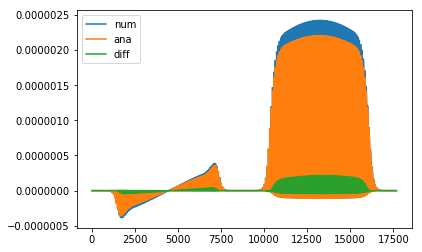

In [43]:
plt.plot(numeric)
plt.plot(analytic)
plt.plot(diff)

plt.legend(['num', 'ana', 'diff'])

In [44]:
np.mean(numeric) / np.mean(analytic)

1.0592481415899162

In [45]:
np.pi/2.

1.5707963267948966

# 3D solution

In [46]:
ny = 2
hy = np.ones(ny)*2*np.pi / ny
mesh3D = discretize.CylMesh([mesh2D.hx, hy, mesh2D.hz], mesh2D.x0)

/anaconda/lib/python2.7/site-packages/matplotlib/projections/polar.py:65: RuntimeWarning: invalid value encountered in less
  mask = r < 0


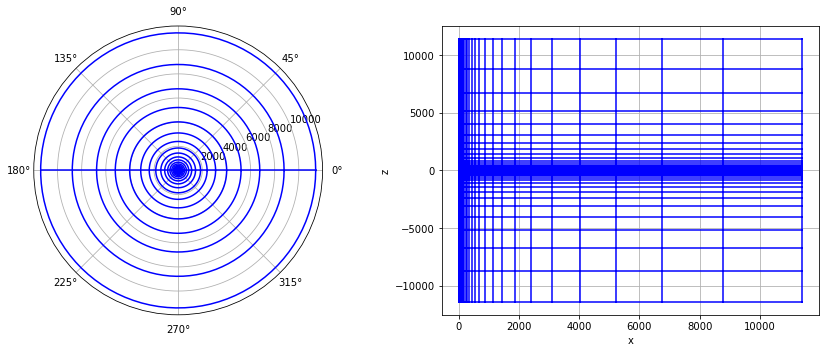

In [47]:
mesh3D.plotGrid()

In [48]:
dg_x = np.zeros(mesh3D.vnF[0])
dg_y = np.zeros(mesh3D.vnF[1])
dg_z = np.zeros(mesh3D.vnF[2])

wire_in_boreholex = (
    (mesh3D.gridFz[:, 0] < src_a[0] + mesh3D.hx.min()/2.) &
    (mesh3D.gridFz[:, 0] > src_a[0] - mesh3D.hx.min()/2.)
)
wire_in_boreholez = (
    (mesh3D.gridFz[:, 2] >= src_a[2] - 0.5*mesh3D.hz.min()) &
    (mesh3D.gridFz[:, 2] < src_b[2] + 1.5*mesh3D.hz.min())
)

wire_in_borehole = wire_in_boreholex & wire_in_boreholez

dg_z[wire_in_borehole] = 1.

# assemble the source (downhole grounded primary)
dg = np.hstack([dg_x, dg_y, dg_z])
src3D = TDEM.Src.RawVec_Grounded([], s_e=dg/mesh3D.area)

In [49]:
# define a problem - the statement of which discrete pde system we want to solve
prob3D = TDEM.Problem3D_j(mesh3D, timeSteps = timeSteps, sigmaMap=Maps.SurjectFull(mesh3D))  
prob3D.solver = Pardiso

survey3D = TDEM.Survey([src3D])

# tell the problem and survey about each other - so the RHS can be constructed for 
# the problem and the resulting fields and fluxes can be sampled by the receiver. 
prob3D.pair(survey3D)  

print('The maximum time is {:1.1e}'.format(prob.times[-1]))

The maximum time is 1.2e-03


In [50]:
%%time
fields3D = prob3D.fields(np.r_[sigma_back])

KeyboardInterrupt: 

In [ ]:
def plot_j(
    time_ind=0 # which frequency would you like to look at?
):
    fig, ax = plt.subplots(1,3, figsize=(15,5))
    
    # Numeric solution
    numeric = casingSimulations.face3DthetaSlice(
        mesh3D, fields3D[:, 'j', time_ind], theta_ind=0
    )

#     numeric = fields[src, 'j', time_ind]
    
    # analytic solution
    ana_dipole.time = prob.times[time_ind]
    
    j_x_ana = utils.mkvc(ana_dipole.current_density(mesh2D.gridFx)[:,0], 2)
    j_z_ana = utils.mkvc(ana_dipole.current_density(mesh2D.gridFz)[:,2], 2)
    analytic = np.vstack([j_x_ana, j_z_ana])*mesh3D.vnC[1]  # since we normalize the current going through the faces to be 1
    
    diff = numeric - analytic
    
    # plotting params
    max_field = np.abs(numeric).max() #use to set colorbar limits
    cb_range = 1e4  # dynamic range of colorbar
    
    titles = ['num', 'ana', 'diff']
    field_to_plot = [numeric, analytic, diff]
    for i, a in enumerate(ax):
        cb = plt.colorbar(mesh2D.plotImage(
            field_to_plot[i], 
            vType='F', view='vec', 
            range_x=[-100., 100.], range_y=[-100., 100.],
            pcolorOpts={
                    'norm': LogNorm(), 
                    'cmap': plt.get_cmap('viridis')
                },
            streamOpts={'color': 'w'}, mirror=True, ax=a, 
            clim=[max_field/cb_range, max_field]
        )[0], ax=a)

        cb.set_label('j')

        # plot the surface of the earth
        a.plot(np.r_[-200, 200], np.r_[0., 0.], 'w:')

        # give it a title
        a.set_title(
            '{title} j, {time:10.2e} s'.format(
                title=titles[i],
                time=prob.times[time_ind]
            )
        )
    
    plt.tight_layout()
    plt.show()
    return ax

ipywidgets.interact(
    plot_j, 
    time_ind=ipywidgets.IntSlider(min=2, max=len(prob.timeSteps)-1, value=1) 
)